# Section 1: Text Classification

## Text Classification With The Torchtext Library


https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

### Access to the raw dataset iterators

In [ ]:
import torch
from torchtext.datasets import AG_NEWS

In [ ]:
AG_NEWS

<function torchtext.datasets.ag_news.AG_NEWS>

AG_NEWS consits of tupel of label and text.

In [ ]:
train_iter = AG_NEWS(split='train')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')
print(f'example of AG_NEWs : {next(train_iter)}')

example of AG_NEWs : (3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
example of AG_NEWs : (3, 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')
example of AG_NEWs : (3, "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")


### Prepare data processing pipeline

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter =  AG_NEWS(split='train')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
# convert a list of tokens into integers
vocab(['here','is' ,'an', 'example'])

[475, 21, 30, 5297]

Let's build fuctions for process text and label. 

The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) -1

In [ ]:
text_pipeline('here is an example')

[475, 21, 30, 5297]

In [ ]:
label_pipeline('10')

9

### Generate data batch and iterator

In [ ]:
from torch.utils.data import DataLoader

def collate_batch(batch):
  label_list, text_list, offsets = [], [], [0]

  for (_label, _text) in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    offsets.append(processed_text.size(0))
  label_list = torch.tensor(label_list, dtype=torch.int64)  
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  text_list = torch.cat(text_list)
  return label_list, text_list, offsets

In [ ]:
train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
print(f'length of train_iter is : {len(train_iter)} and length of dataloader is : {len(dataloader)}')

length of train_iter is : 120000 and length of dataloader is : 15000


Let's take a look at a batch of the dataloader.

In [ ]:
examples = iter(dataloader)
#unpack examples
label, text , offset = examples.next()
print(f'label shape : {label.shape} ,text shape : {text.shape}, length of offset : {len(offset)}')
print(f'offset -> {offset}')
print(f'length of the first text in the batch : {offset[1]}')

label shape : torch.Size([8]) ,text shape : torch.Size([338]), length of offset : 8
offset -> tensor([  0,  29,  71, 111, 151, 194, 242, 289])
length of the first text in the batch : 29


Offset is a list with a length of 9(batch size + 1) that stores the length of each text in the batch.

### Define the model

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)
    self.init_weights()

  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)  


### Initiate an instance

In [ ]:
train_iter = AG_NEWS(split='train')
labels = [label for (label, text) in train_iter]

In [ ]:
classes = set(labels)

distribution = {}
for i in classes:
  distribution[i] = labels.count(i)

print(f'distribution in each class : {distribution}')

distribution in each class : {1: 30000, 2: 30000, 3: 30000, 4: 30000}


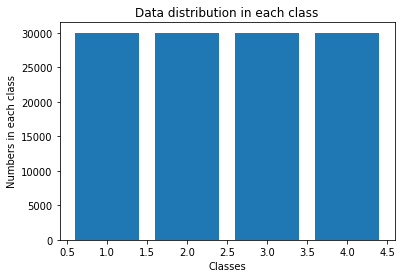

In [ ]:
import matplotlib.pyplot as plt

num_in_class = [distribution[i] for i in range(1,5)]
plt.bar([1,2,3,4], num_in_class)
plt.xlabel('Classes')
plt.ylabel('Numbers in each class')
plt.title('Data distribution in each class')
plt.show()

In [ ]:
num_class = len(classes)
vocab_size = len(vocab)
embed_dim = 64

model = TextClassificationModel(vocab_size, embed_dim, num_class)

### Define functions to train the model and evalute results

In [ ]:
import time 

def train(dataloader):
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 500
  start_time = time.time()

  for idx, (label, text, offsets) in enumerate(dataloader):

    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) ####
    optimizer.step()

    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)

   
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print('| epoch {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))

      total_acc, total_count = 0, 0
      start_time = time.time()  
    

def evaluate(dataloader):
  model.eval()
  total_acc , total_count = 0, 0
  
  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
    return total_acc/total_count


### Split the dataset and run the model

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

epochs = 10
learning_rate = 5
batch_size = 64

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

In [ ]:
train_iter, test_iter= AG_NEWS()

In [ ]:
print(f'length of train iter : {len(train_iter)}')
print(f'length of test iter : {len(test_iter)}')

length of train iter : 120000
length of test iter : 7600


In [ ]:
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

In [ ]:
train_dataset[0]

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [ ]:
test_dataset[0]

(3,
 "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.")

In [ ]:
# split train_data set into train(0.95) and valid(0.05)
num_train = int(len(train_dataset)*0.95)

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [ ]:
print(f'length of split train : {len(split_train_)}')
print(f'length of split valid : {len(split_valid_)}')

length of split train : 114000
length of split valid : 6000


In [ ]:
train_dataloader = DataLoader(split_train_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(split_valid_, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [ ]:
print(f'length of train dataloader : {len(train_dataloader)}')
print(f'length of valid dataloader : {len(valid_dataloader)}')
print(f'length of test dataloader : {len(test_dataloader)}')

length of train dataloader : 1782
length of valid dataloader : 94
length of test dataloader : 119


#### Train the model

In [ ]:
for epoch in range(1, epochs+1):
  epoch_start_time = time.time()
  train(train_dataloader)
  accu_val = evaluate(valid_dataloader)
  if total_accu is not None and total_accu > accu_val:
    scheduler.step()
  else:
    total_accu = accu_val
  print('-'*59)
  print('| end of epoch {:3d} | time : {:5.2f}s | valid accuracy {:8.3f}'.format(epoch, time.time() - epoch_start_time, accu_val))  

  print('-'*59)

| epoch   1 |   500/ 1782 batches | accuracy    0.684
| epoch   1 |  1000/ 1782 batches | accuracy    0.852
| epoch   1 |  1500/ 1782 batches | accuracy    0.876
-----------------------------------------------------------
| end of epoch   1 | time : 15.44s | valid accuracy    0.884
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.895
| epoch   2 |  1000/ 1782 batches | accuracy    0.898
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time : 15.03s | valid accuracy    0.900
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.915
| epoch   3 |  1000/ 1782 batches | accuracy    0.913
| epoch   3 |  1500/ 1782 batches | accuracy    0.913
-----------------------------------------------------------
| end of epoch   3 | time : 15.28s | valid accuracy    0.907
-------------------------------

### Evalute the model with test dataset

In [ ]:
print('Cheking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Cheking the results of test dataset.
test accuracy    0.907


### Test on a random new

In [ ]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
  with torch.no_grad():
    text = torch.tensor(text_pipeline(text))
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item() + 1


In [ ]:
ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

print(f'This is {ag_news_label[predict(ex_text_str, text_pipeline)]} news')

This is Sports news


## Hamshahri Newspaper Text Classification

In this section, we want to work on the Hamshahri corpus dataset. From the rar file, we use data in ham2->corpus. This directory consists of news files from 1996 to 2007. We want to work on one year's news. I select 2001 news.


Link of Hamshahri Corpus
https://dbrg.ut.ac.ir/hamshahri/

In [1]:
!pip install parsivar

     |████████████████████████████████| 36.2 MB 58 kB/s 
     |████████████████████████████████| 1.5 MB 55.2 MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492971 sha256=e74c3ad14659e24884a7710adb56bc309c8fde7309b4b94e0587f5fb2e07d1ab
  Stored in directory: /root/.cache/pip/wheels/ae/67/7a/49cbf08f64d3f76a26eceaf0e481a40e233f05d4356875cbed
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=f375997540fa52ffe9b8b3aff139d8d3efac8354caced84ff3fbeade72d26f08
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
!pip install python-bidi
!pip install arabic-reshaper

In [3]:
# Loading NLTk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# NLP libraries
import parsivar
from parsivar import Normalizer, Tokenizer, FindStems, FindChunks, DependencyParser

# Libraries for parsing XML
import xml.etree.ElementTree as ET
import pandas as pd  
import csv
import bs4
import re

# plot
import matplotlib.pyplot as plt

# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape


import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unrar x "/content/drive/MyDrive/AI-Internship/HAM2.rar" "/content/drive/MyDrive/AI-Internship/HAM2"

In [ ]:
# Let's take a look at folders inside the path
import os
os.listdir("/content/drive/MyDrive/AI-Internship/HAM2")

['1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007']

In [ ]:
import os
print(f'number of files in 2001 folder : {len(os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001"))}')

number of files in 2001 folder : 299


In [ ]:
print(f'some files in 200l : {os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001")[:10]}')

some files in 200l : ['hamshahri.dtd', 'HAM2-010101.xml', 'HAM2-010116.xml', 'HAM2-010107.xml', 'HAM2-010110.xml', 'HAM2-010114.xml', 'HAM2-010113.xml', 'HAM2-010104.xml', 'HAM2-010111.xml', 'HAM2-010106.xml']


As we see, we have XML files. So, we should convert XML files into CSV files

In [ ]:
#Store file names in the filename. We don't need a DTD file. So, we select elements from index 1 to the end.
filename = os.listdir("/content/drive/MyDrive/AI-Internship/HAM2/2001")[1:]
print(f'number of XML files in 2001 : {len(filename)}')

number of XML files in 2001 : 298


In [ ]:
# Reading the first file
filepath = "/content/drive/MyDrive/AI-Internship/HAM2/2001"

file_path_file1 = os.path.join(filepath, filename[0])
tree = ET.parse(file_path_file1)
root = tree.getroot()
print(f'root.tag and root.atrib : {root.tag} {root.attrib}')

root.tag and root.atrib : HAMSHAHRI2 {}


It's helpful to know all elements in the entire tree. 

In [ ]:
elements = [elem.tag for elem in root.iter()]
print(f'all elements in the tree : {set(elements)}')

all elements in the tree : {'IMAGE', 'DOCID', 'HAMSHAHRI2', 'ISSUE', 'ORIGINALFILE', 'DATE', 'COPYRIGHT', 'TITLE', 'TEXT', 'CAT', 'DOC', 'DOCNO'}


In [ ]:
child_list = []
for child in root:    
  child_list.append([child.tag, child.attrib]) 
# print children of root
print(f'children of root : {child_list}')

children of root : [['COPYRIGHT', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}], ['DOC', {}]]


In [ ]:
print(f'number of childrens in first file : {len(child_list)}')

number of childrens in first file : 56


Let's print whole document of a child.


In [ ]:
print(ET.tostring(child, encoding='utf8').decode('utf8'))

<?xml version='1.0' encoding='utf8'?>
<DOC>
<DOCID>HAM2-791012-055</DOCID>
<DOCNO>HAM2-791012-055</DOCNO>
<ORIGINALFILE>/1379/791012/vrzsh.htm</ORIGINALFILE>
<ISSUE>دوشنبه 12 1 jan 2001 دي 1379،، شماره 2305</ISSUE>
<DATE calender="Western">2001-01-01</DATE>
<DATE calender="Persian">1379/10/12</DATE>
<CAT xml:lang="fa">ورزش</CAT>
<CAT xml:lang="en">Sport</CAT>
<TITLE>
تيم فوتبال ايتاليا با" بونين سنيا" به 
تهران مي آيد
</TITLE>
<TEXT>
گروه ورزشي: فدراسيون فوتبا ل ايتاليا اعلام كرد كه اين 
كشور با تيم زير 21 سال خود و با مربيگري روبرتو بونين 
سنيا در رقابتهاي چهارجانبه جام تمدنها در ايران شركت 
مي كند. 
مسابقات فوتبال جام تمدنهااز تاريخ 28 تا 30 دي ماه 
امسال با شركت تيمهاي ملي ايران، مصر، چين و تيم زير 21
سال ايتاليا در ورزشگاه آزادي تهران برگزار مي شود. اين 
مسابقات در راستاي ابتكار جمهوري اسلامي براي نامگذاري 
سال 2001 به عنوان سال گفتگوي بين تمدنها برگزار مي شود. 
لوئيجي نري رئيس اداره مطبوعات فدراسيون فوتبال ايتاليا
در پاسخ به اين پرسش كه چرا ايتاليا با تيم زير 21 سال 
خود در اين جا

In [ ]:
for child in root.findall('./DOC/TEXT/'):
  print(child.tag, child.attrib)

IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}
IMAGE {}


As we see, some DOCs has an IMAGE child. So, the parser read only image in this situation. Because of that we should use complex sintax for read CDATA after IMAGE child in DOC. 

Now, we should convert XML files into CSV files.

### Convert XML to CSV

In [ ]:
from xml.etree.ElementTree import ParseError

In [ ]:
cols = ['id', 'title','text','label']
csv_file = open('hamshahri-2001.csv', 'w', newline='')
csvwriter = csv.writer(csv_file, lineterminator ='\n')
csvwriter.writerow(cols)

def make_csv(folderpath, xmlfilename, csvwriter, csv_file):
  
  try:
    tokenizer = Tokenizer()
    # parse each xml file
    for i in range(len(xmlfilename)):

      #Parse XML file
      tree = ET.parse(os.path.join(folderpath, xmlfilename[i]))
      root = tree.getroot()
   
  
      for elem in root.findall("DOC") :
        rows = []

        # parse DOCID
        id = elem.find("DOCID")
        if id != None:
          id = id.text
        rows.append(id)

        # parse TITLE
        title = elem.find("TITLE")
        if title != None:
          title = re.sub('\n', ' ', title.text)
        rows.append(title)  

        # parse TEXT (thanks to https://stackoverflow.com/questions/68847136/parsing-xml-cdata-section-and-convert-it-to-csv-using-elementtree-python
        # I found out how to read CDATA *after* IMAGE child in some DOCs)
        sent = elem.find("TEXT")
        if sent != None:
          sentence = list(sent)[-1].tail.strip() if list(sent) else sent.text.strip()
          sentence = re.sub('\n', ' ', sentence)
          select_sentence = tokenizer.tokenize_sentences(sentence)[:2]
          select_sentence = ''.join(select_sentence)
        rows.append(select_sentence)

        # parse CAT
        label = elem.find('CAT')
        if label != None:
          label = label.text
        rows.append(label)  

        # write rows in csv file
        csvwriter.writerow(rows)
    csv_file.close()
  
  except ParseError:
    print(xmlfilename[i])
    raise  

In [ ]:
filepath = "/content/drive/MyDrive/AI-Internship/HAM2/2001"

make_csv(filepath, filename, csvwriter, csv_file)

### Read dataset from CSV

In [ ]:
data = pd.read_csv('/content/hamshahri-2001.csv')
data.head()

,id,title,text,label
0,HAM2-791012-001,بي تاب براي بازي زندگي,نگاهي به آثار و زندگي آندره مالرو مالرو هم هما...,ادب و هنر
1,HAM2-791012-002,نقش رسانه هاي جمعي در ايجاد احساس امنيت,"نخست بايد بدانيم كه به همان ميزان كه ""امنيت ""د...",اجتماعی
2,HAM2-791012-003,مدير عامل ايرنا بازجويي شد,گروه اجتماعي: مديرعامل سازمان خبرگزاري جمهوري ...,اجتماعی
3,HAM2-791012-004,رزمايش دريايي غدير 79در درياي عمان آغاز شد,"رزمايش دريايي منطقه اي ""غدير 79"" از ديروز در ف...",اجتماعی
4,HAM2-791012-005,چهارمين جلسه دادگاه غيرعلني قتل هاي زنجيره ا...,گروه اجتماعي: به گزارش سازمان قضائي نيروهاي مس...,اجتماعی


In [ ]:
data.shape

(22254, 4)

In [ ]:
data['label'][0]

'ادب و هنر'

In [ ]:
data['text'][0]

'نگاهي به آثار و زندگي آندره مالرو مالرو هم همانند بسياري ديگر در ايران ناشناخته مانده  است . اما به واقع شايد دليل عمده آن كه مالرو تا حدودي  در كشور ما، يا حتي برخي كشورهاي ديگر ناشناخته مانده،  واقع شدن و همزمان شدن نام و ياد او در ميان نام و ياد نويسندگان و روشنفكران بزرگي چون آلبركامو يا ژان پل  سارتر است .'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22254 entries, 0 to 22253
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22254 non-null  object
 1   title   22254 non-null  object
 2   text    22237 non-null  object
 3   label   22254 non-null  object
dtypes: object(4)
memory usage: 695.6+ KB


Let's select rows that have specific value in label columns.

In [ ]:
mask_column = ['ادب و هنر', 'اجتماعی', 'علمی فرهنگی', 'اقتصاد', 'سیاسی', 'ورزش']

In [ ]:
dataset = data.copy()
df = dataset.loc[dataset['label'].isin(mask_column)]

In [ ]:
df.head()

,id,title,text,label
0,HAM2-791012-001,بي تاب براي بازي زندگي,نگاهي به آثار و زندگي آندره مالرو مالرو هم هما...,ادب و هنر
1,HAM2-791012-002,نقش رسانه هاي جمعي در ايجاد احساس امنيت,"نخست بايد بدانيم كه به همان ميزان كه ""امنيت ""د...",اجتماعی
2,HAM2-791012-003,مدير عامل ايرنا بازجويي شد,گروه اجتماعي: مديرعامل سازمان خبرگزاري جمهوري ...,اجتماعی
3,HAM2-791012-004,رزمايش دريايي غدير 79در درياي عمان آغاز شد,"رزمايش دريايي منطقه اي ""غدير 79"" از ديروز در ف...",اجتماعی
4,HAM2-791012-005,چهارمين جلسه دادگاه غيرعلني قتل هاي زنجيره ا...,گروه اجتماعي: به گزارش سازمان قضائي نيروهاي مس...,اجتماعی


Description of each columns:


*   id : DOCID (persian date)
*   title : title of new
*   text : two first sentece of new
*   label : category of new (we have 6 category in df)





In [ ]:
print(f'df shape : {df.shape}')

df shape : (13646, 4)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13646 entries, 0 to 22253
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      13646 non-null  object
 1   title   13646 non-null  object
 2   text    13632 non-null  object
 3   label   13646 non-null  object
dtypes: object(4)
memory usage: 533.0+ KB


In [ ]:
df.isnull().sum()

id        0
title     0
text     14
label     0
dtype: int64

As we see, we have missing values in our dataset. So, I drop rows with any non value in it.

In [ ]:
# drop all rows with any NaN and NaT values
df1 = df.dropna()

In [ ]:
df1.shape

(13632, 4)

In [ ]:
df1.isnull().sum()

id       0
title    0
text     0
label    0
dtype: int64

As we see, our dataset is treated and doesn't have any null value.

Let's take a look at number of data in each category.

In [ ]:
df1.label.value_counts()

سیاسی          3219
اقتصاد         3034
اجتماعی        2135
ورزش           2113
علمی فرهنگی    1969
ادب و هنر      1162
Name: label, dtype: int64

In [ ]:
list(df1.label.value_counts())

[3219, 3034, 2135, 2113, 1969, 1162]

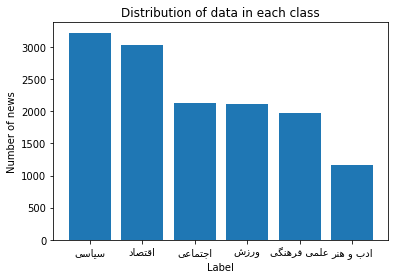

In [ ]:
# destribution of data in each class
distribution  = list(df1.label.value_counts())

classes = ['سیاسی','اقتصاد','اجتماعی','ورزش','علمی فرهنگی','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of data in each class")
plt.show()

In [ ]:
df1['text'][100]

'گروه سياسي: به مناسبت ششمين سال درگذشت مرحوم مهندس  مهدي بازرگان پنجشنبه اين هفته مراسمي از ساعت 3014 دقيقه در حسينيه ارشاد برگزار مي شود .  اسامي سخنرانان و عنوانهاي سخنراني اين مراسم هنوز اعلام  نشده است .'

As we see, we hava numbers in our text. They don't make sense for our model and predict the label, so, we should delete them to have better result.

### Text preprocessing

#### Stop Words

Now, we should process the text. First we read stopwords from file that is in Kharazi. (https://github.com/kharazi/persian-stopwords/blob/master/persian)

In [ ]:
# define a function to read file
def readFile(filename):
  fileObj = open(filename, 'r') # open the file in read mode
  words = fileObj.read().splitlines() # puts the file into an array
  fileObj.close()
  return words

In [ ]:
stopwords = readFile('/content/drive/MyDrive/AI-Internship/persian_stopwords_kharazi.txt')
print(f'length of stop words : {len(stopwords)}')

length of stop words : 1370


In [ ]:
print(f'some of stop words : {stopwords[:100]}')

some of stop words : ['!', '"', '#', '(', ')', '*', ',', '-', '.', '/', ':', '[', ']', '«', '»', '،', '؛', '؟', 'آباد', 'آخ', 'آخر', 'آخرها', 'آخه', 'آدمهاست', 'آرام', 'آرام آرام', 'آره', 'آری', 'آزادانه', 'آسان', 'آسیب پذیرند', 'آشنایند', 'آشکارا', 'آقا', 'آقای', 'آقایان', 'آمد', 'آمدن', 'آمده', 'آمرانه', 'آن', 'آن گاه', 'آنان', 'آنانی', 'آنجا', 'آنرا', 'آنطور', 'آنقدر', 'آنها', 'آنهاست', 'آنچنان', 'آنچنان که', 'اونجور', 'اونجوری', 'اونجوری که', 'آنچه', 'آنکه', 'آنگاه', 'آن\u200cها', 'آهان', 'آهای', 'آور', 'آورد', 'آوردن', 'آورده', 'آوه', 'آی', 'آیا', 'آید', 'آیند', 'ا', 'اتفاقا', 'اثرِ', 'اجراست', 'احتراما', 'احتمالا', 'احیاناً', 'اخیر', 'اخیراً', 'اری', 'از', 'از آن پس', 'از بس که', 'از جمله', 'ازاین رو', 'ازجمله', 'ازش', 'اساسا', 'اساساً', 'است', 'استفاد', 'استفاده', 'اسلامی اند', 'اش', 'اشتباها', 'اشکارا', 'اصلا', 'اصلاً', 'اصولا', 'اصولاً']


In [ ]:
'یک' in stopwords

True

#### Preprocessing function

Let's define a function for preprocessing text.

In [ ]:
def data_preprocessing(review, stopwords):
  try:

    # delete category name from first of the news
    # in order to prevent model from bias
    review = re.sub('گروه سياسي:','',review)
    review = re.sub('گروه اجتماعي:','', review)
    review = re.sub('گروه هنري:','', review)
    review = re.sub('گروه علمي فرهنگي:','', review)
    review = re.sub('گروه ورزشي:','', review)
    review = re.sub('گروه اقتصادي:','', review)

    # normalizing the text
    # first we should normalize text in order to convert persian numbers into english numbers then
    # with following function (filter) delete them
    normalizer = Normalizer()
    review = normalizer.normalize(review)

    # delete english characters and numbers from sentences
    review = filter(lambda x: x in string.whitespace or x not in string.printable, review)
    review = ''.join(ch for ch in list(review))
    
    # word tokenization
    tokenizer = Tokenizer()
    words = tokenizer.tokenize_words(review)

    # remove stop words
    words_without_stopword = filter(lambda x: x not in stopwords, words)
    words_without_stopwords = list(words_without_stopword)
    
    # stemming 
    stemmer = FindStems()
    review = [stemmer.convert_to_stem(word) for word in words_without_stopwords]
    
    # join words in preprocessed review
    review = ' '.join(review)
    
    return review

  except TypeError:
    print(review)
    raise

Because we have many rows, for speeding up this function, we should use pandarallel.

In [ ]:
! pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.2-py3-none-any.whl size=18398 sha256=23bac7a0efcb87e276328136e4d74ae5eb3f8c57165b2b8ef936d009a60e2bba
  Stored in directory: /root/.cache/pip/wheels/b5/6d/51/9ece2eaf007ea3f7fb0ce053c5773b2eb0d308887da3af12c1
Successfully built pandarallel


In [ ]:
from pandarallel import pandarallel
import string

In [ ]:
# initialize pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df1['preprocessing_text'] = df1['text'].parallel_apply(lambda text: data_preprocessing(text, stopwords))

In [ ]:
# #Save dataframe
# df1.to_pickle('/content/drive/MyDrive/AI-Internship/hamshahri_preprocessed')

In [ ]:
#load the preprocessing dataframe
df1 = pd.read_pickle(r'/content/drive/MyDrive/AI-Internship/hamshahri_preprocessed')

In [ ]:
df1.head()

,id,title,text,label,preprocessing_text
0,HAM2-791012-001,بي تاب براي بازي زندگي,نگاهي به آثار و زندگي آندره مالرو مالرو هم هما...,ادب و هنر,نگاه اثر زندگی آندره مالرو مالرو ایران ناشناخت...
1,HAM2-791012-002,نقش رسانه هاي جمعي در ايجاد احساس امنيت,"نخست بايد بدانيم كه به همان ميزان كه ""امنيت ""د...",اجتماعی,دانست&دان امنیت جامعه حائز اهمیت احساس امنیت ا...
2,HAM2-791012-003,مدير عامل ايرنا بازجويي شد,گروه اجتماعي: مديرعامل سازمان خبرگزاري جمهوري ...,اجتماعی,مدیرعامل سازمان خبرگزاری جمهوری اسلامی ایرنا م...
3,HAM2-791012-004,رزمايش دريايي غدير 79در درياي عمان آغاز شد,"رزمايش دريايي منطقه اي ""غدير 79"" از ديروز در ف...",اجتماعی,رزمایش دریایی منطقه‌ای غدیر فاصله تنگه هرمز مر...
4,HAM2-791012-005,چهارمين جلسه دادگاه غيرعلني قتل هاي زنجيره ا...,گروه اجتماعي: به گزارش سازمان قضائي نيروهاي مس...,اجتماعی,گزارش سازمان قضائی نیرو مسلح چهارمین جلسه دادگ...


Let's compare one example before and after preprocessing.

In [ ]:
print('df1.text[100] before preprocessing ->')
print(df1['text'][100])
print('df1.text[100] after preprocessing ->')
print(df1['preprocessing_text'][100])

df1.text[100] before preprocessing ->
گروه سياسي: به مناسبت ششمين سال درگذشت مرحوم مهندس  مهدي بازرگان پنجشنبه اين هفته مراسمي از ساعت 3014 دقيقه در حسينيه ارشاد برگزار مي شود .  اسامي سخنرانان و عنوانهاي سخنراني اين مراسم هنوز اعلام  نشده است .
df1.text[100] after preprocessing ->
مناسبت ششمین سال درگذشت مرحوم مهندس مهدی بازرگان پنجشنبه هفته مراسم ساعت دقیقه حسینیه ارشاد برگزار اسم سخنران عنوان سخنرانی مراسم اعلام‌نشده‌است


### EDA on preprocessed dataset

In [ ]:
Label = df1.groupby('label')
Label.count()

,id,title,text,preprocessing_text
label,,,,
اجتماعی,2135,2135,2135,2135
ادب و هنر,1162,1162,1162,1162
اقتصاد,3034,3034,3034,3034
سیاسی,3219,3219,3219,3219
علمی فرهنگی,1969,1969,1969,1969
ورزش,2113,2113,2113,2113


In [ ]:
Label.describe()

id  ... preprocessing_text
            count  ...               freq
label              ...                   
اجتماعی      2135  ...                  1
ادب و هنر    1162  ...                  1
اقتصاد       3034  ...                  1
سیاسی        3219  ...                  2
علمی فرهنگی  1969  ...                  2
ورزش         2113  ...                  2

[6 rows x 16 columns]

### World Cloud

https://www.datacamp.com/community/tutorials/wordcloud-python

In [ ]:
!pip install wordcloud-fa

     |████████████████████████████████| 76 kB 2.8 MB/s 
     |████████████████████████████████| 364 kB 11.1 MB/s 
     |████████████████████████████████| 316 kB 51.1 MB/s 
     |████████████████████████████████| 233 kB 71.3 MB/s 
     |████████████████████████████████| 1.4 MB 42.6 MB/s 
  Created wheel for wordcloud-fa: filename=wordcloud_fa-0.1.8-py3-none-any.whl size=71015 sha256=6881f4cf9baca2b75404c7486d747d341819746506291ed732a2ae0e73cd8117
  Stored in directory: /root/.cache/pip/wheels/ae/a0/f3/81d930500493324929d26658e5a3ccff5ccc8644131ad1aadc
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394485 sha256=0cd5093eb1bbb58c7210719d1730d3959923e0f781e0b7e139a3bf4d861d7de1
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153862 sha256=160c7e41d54466ba579966bf2ce28e770d7aa74826aef803cb2e0937aa46af89
  Stored in directory:

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# for supporting persian language
from wordcloud_fa import WordCloudFa 

text : نگاه اثر زندگی آندره مالرو مالرو ایران ناشناخته مانده واقع دلیل مالرو حدودی کشور کشور ناشناخته مانده واقع یاد یاد نویسندگان روشنفکر بزرگی آلبرکامو ژان پل سارتر


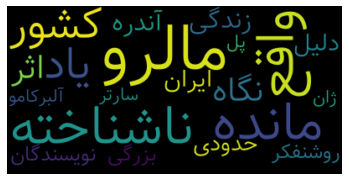

In [ ]:
# start with one text
text = df1.preprocessing_text[0]
print(f'text : {text}')

# create and generate a word cloud image
wordcloud = WordCloudFa().generate(text)

# display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's change some optional arguments of WordCloud.

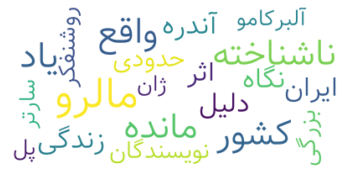

In [ ]:
wordcloud = WordCloudFa(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# save the image in the img folder
wordcloud.to_file('/content/drive/MyDrive/AI-Internship/first_text.png')

Let's take a look at word frequency in each label.

#### Politics words frequency

In [ ]:
df_politics = df1.loc[df1['label'] == 'سیاسی']

text_politics = " ".join(text for text in df_politics['preprocessing_text'])

In [ ]:
print ("There are {} words in the combination of all politics texts.".format(len(text_politics)))

There are 885887 words in the combination of all politics texts.


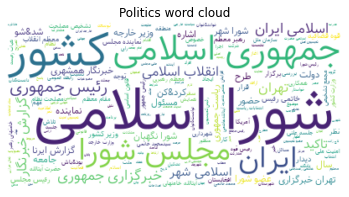

In [ ]:
# Generate a word cloud image for politics
wordcloud_politics = WordCloudFa(background_color="white").generate(text_politics)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_politics, interpolation='bilinear')
plt.axis("off")
plt.title('Politics word cloud')
plt.show()

#### Economy words frequency

In [ ]:
df_economy = df1.loc[df1['label'] == 'اقتصاد']

text_economy = " ".join(text for text in df_economy['preprocessing_text'])
print ("There are {} words in the combination of all economy texts.".format(len(text_economy)))

There are 941831 words in the combination of all economy texts.


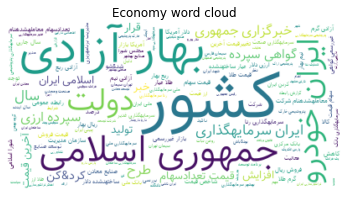

In [ ]:
# Generate a word cloud image for economy
wordcloud_economy = WordCloudFa(background_color="white").generate(text_economy)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_economy, interpolation='bilinear')
plt.axis("off")
plt.title('Economy word cloud')
plt.show()

#### Social words frequency

In [ ]:
df_social = df1.loc[df1['label'] == 'اجتماعی']

text_social = " ".join(text for text in df_social['preprocessing_text'])
print ("There are {} words in the combination of all social texts.".format(len(text_social)))

There are 513715 words in the combination of all social texts.


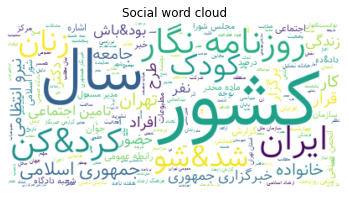

In [ ]:
# Generate a word cloud image for economy
wordcloud_social = WordCloudFa(background_color="white").generate(text_social)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_social, interpolation='bilinear')
plt.axis("off")
plt.title('Social word cloud')
plt.show()

#### Sport words frequency

In [ ]:
df_sport = df1.loc[df1['label'] == 'ورزش']

text_sport = " ".join(text for text in df_sport['preprocessing_text'])
print ("There are {} words in the combination of all sport texts.".format(len(text_sport)))

There are 452218 words in the combination of all sport texts.


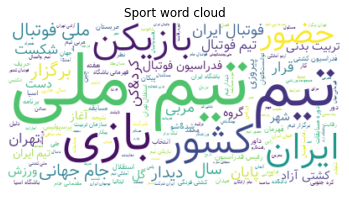

In [ ]:
# Generate a word cloud image for economy
wordcloud_sport = WordCloudFa(background_color="white").generate(text_sport)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_sport, interpolation='bilinear')
plt.axis("off")
plt.title('Sport word cloud')
plt.show()

#### Science and Culture words frequency

In [ ]:
df_science = df1.loc[df1['label'] == 'علمی فرهنگی']

text_science = " ".join(text for text in df_science['preprocessing_text'])
print ("There are {} words in the combination of all science texts.".format(len(text_science)))

There are 466074 words in the combination of all science texts.


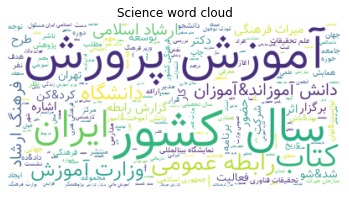

In [ ]:
# Generate a word cloud image for economy
wordcloud_science = WordCloudFa(background_color="white").generate(text_science)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_science, interpolation='bilinear')
plt.axis("off")
plt.title('Science word cloud')
plt.show()

#### Literature and Art words frequency

In [ ]:
df_art = df1.loc[df1['label'] == 'ادب و هنر']

text_art = " ".join(text for text in df_art['preprocessing_text'])
print ("There are {} words in the combination of all art texts.".format(len(text_art)))

There are 279030 words in the combination of all art texts.


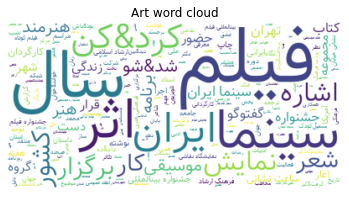

In [ ]:
# Generate a word cloud image for economy
wordcloud_art = WordCloudFa(background_color="white").generate(text_art)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_art, interpolation='bilinear')
plt.axis("off")
plt.title('Art word cloud')
plt.show()

#### Mask Image with Politics text

In [ ]:
import numpy as np
from PIL import Image

iran_mask = np.array(Image.open("/content/drive/MyDrive/AI-Internship/iran.jpg"))

iran_mask = iran_mask.reshape((iran_mask.shape[0],-1), order='F')

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [ ]:
# Transform your mask into a new one that will work with the function:
transformed_iran_mask = np.ndarray((iran_mask.shape[0],iran_mask.shape[1]), np.int32)

for i in range(len(iran_mask)):
    transformed_iran_mask[i] = list(map(transform_format, iran_mask[i]))

In [ ]:
transformed_iran_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

When we use transformed_iran_mask, it gives us a ValueError that is canvas is to small. I couldn't find anyting to fix this bug and in order to fix it, I used original image as a mask.

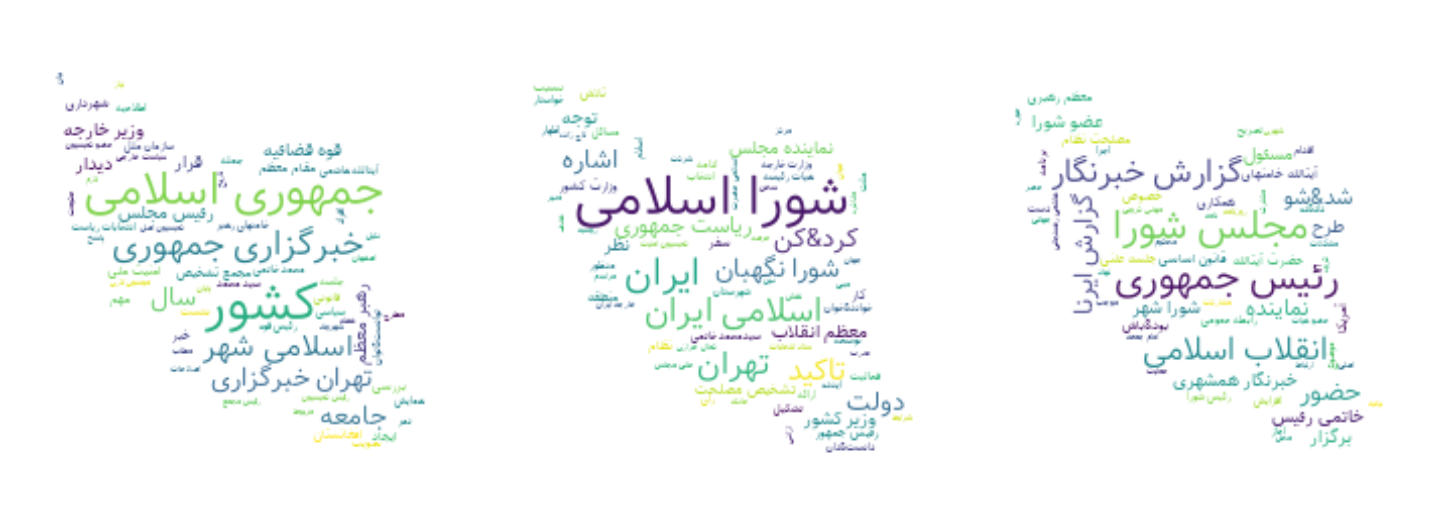

In [ ]:
# Create a word cloud image
wc = WordCloudFa(background_color="white", mask=iran_mask).generate(text_politics)

# store to file
wc.to_file("/content/drive/MyDrive/AI-Internship/iran_mask.jpg")

# show
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Remove irrelevant columns

In [ ]:
ham_data = df1.copy()
ham_data.drop(labels=['id', 'title', 'text'], axis=1, inplace=True) # remove useless columns

ham_data.head()

,label,preprocessing_text
0,ادب و هنر,نگاه اثر زندگی آندره مالرو مالرو ایران ناشناخت...
1,اجتماعی,دانست&دان امنیت جامعه حائز اهمیت احساس امنیت ا...
2,اجتماعی,مدیرعامل سازمان خبرگزاری جمهوری اسلامی ایرنا م...
3,اجتماعی,رزمایش دریایی منطقه‌ای غدیر فاصله تنگه هرمز مر...
4,اجتماعی,گزارش سازمان قضائی نیرو مسلح چهارمین جلسه دادگ...


In [ ]:
print(f'ham data shape : {ham_data.shape}')

ham data shape : (13632, 2)


### Label Enconding

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ham_data['label'] = le.fit_transform(ham_data['label'])

In [ ]:
ham_data.head()

,label,preprocessing_text
0,1,نگاه اثر زندگی آندره مالرو مالرو ایران ناشناخت...
1,0,دانست&دان امنیت جامعه حائز اهمیت احساس امنیت ا...
2,0,مدیرعامل سازمان خبرگزاری جمهوری اسلامی ایرنا م...
3,0,رزمایش دریایی منطقه‌ای غدیر فاصله تنگه هرمز مر...
4,0,گزارش سازمان قضائی نیرو مسلح چهارمین جلسه دادگ...


In [ ]:
ham_data.label.value_counts()

3    3219
2    3034
0    2135
5    2113
4    1969
1    1162
Name: label, dtype: int64

In [ ]:
print(f'inverse transform of [5, 4, 3, 2, 1, 0] : {list(le.inverse_transform([0, 1, 2, 3, 4, 5]))}')

inverse transform of [5, 4, 3, 2, 1, 0] : ['اجتماعی', 'ادب و هنر', 'اقتصاد', 'سیاسی', 'علمی فرهنگی', 'ورزش']


label encoding (based on lexical order):

*   سیاسی -> 3
*   اقتصاد -> 2
*   اجتماعی-> 0
*   ورزش -> 5
*   علمی فرهنگی -> 4
*   ادب و هنر -> 1


In [ ]:
ham_data.shape

(13632, 2)

In [ ]:
l = [1,2,4,7,8]

In [ ]:
max(l).

8

In [ ]:
len(train_loader)

1091

In [ ]:
l1 = ['سلام','دندان','چشم']
l2 = ['دهان','دندان','گوش','سلام','خوب']

score = list(set.intersection(set(l1), set(l2)))

In [ ]:
score

['دندان', 'سلام']

In [ ]:
len(score)

2

### Split Train, Valid and Test dataset

Let's separate x and y from dataset.
From the dataset we use only preprocessing_text column as x because it contain better information that title column and use label as y.

In [27]:
import torch
import torchtext
from torchtext.legacy import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data.dataset import random_split

from sklearn.model_selection import train_test_split
from torchtext.vocab import Vectors
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#Reproducing same results
SEED = 2019
torch.manual_seed(SEED)

#### Sparate X and y

In [ ]:
X = ham_data['preprocessing_text']

y = ham_data['label']

In [ ]:
print(f'X shape : {X.shape} and y shape : {y.shape}')

X shape : (13632,) and y shape : (13632,)


In [ ]:
type(X)

pandas.core.series.Series

Let's split train and test dataset.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(f'X_train shape : {X_train.shape} and y_train shape : {y_train.shape}')
print(f'X_test shape : {X_test.shape} and y_test shape : {y_test.shape}')

X_train shape : (10905,) and y_train shape : (10905,)
X_test shape : (2727,) and y_test shape : (2727,)


Now, we should split train dataset into train and valid dataset.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(f'X_train shape : {X_train.shape} and y_train shape : {y_train.shape}')
print(f'X_valid shape : {X_valid.shape} and y_valid shape : {y_valid.shape}')
print(f'X_test shape : {X_test.shape} and y_test shape : {y_test.shape}')

X_train shape : (8724,) and y_train shape : (8724,)
X_valid shape : (2181,) and y_valid shape : (2181,)
X_test shape : (2727,) and y_test shape : (2727,)


In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
train_data.head()

,preprocessing_text,label
15564,مخبر کمیسیون امنیت ملی سیاست خارجی مجلس نسبت ا...,3
2892,علی تاجرنیا نماینده مشهد مجلس انتقاد محاکمه سی...,3
5490,عضو کمیسیون صنایع معادن مجلس شورا اسلامی منظور...,2
4761,دریابان علی شمخانی وزیر دفاع جمهوری اسلامی ایر...,3
17676,گردهمایی کارشناس کارکنان سازمان دانش آموخت&آمو...,4


Then we should save our dataset in csv file.

In [ ]:
# #save them
# !mkdir -p /content/drive/MyDrive/AI-Internship/preprocessed_data
# train_data.to_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/train.csv', index=False)
# valid_data.to_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv', index=False)
# test_data.to_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv', index=False)

### Baseline model

Before preparing dataset for neural network, let's test baseline model.

In [21]:
y_pred_test = []
y_actual_test = []

def BaseLine(text_data):

  politics_checklist = ['شورا','اسلامی','جمهوری','مجلس','انقلاب']
  economy_checklist = ['آزادی','بهار','خودرو','دولت','سپرده','سرمایهگذاری']
  social_checklist = ['روزنامه','جامعه','کودک','زنان','خانواده','نگار']
  sport_checklist = ['تیم','ملی','بازی','فوتبال','بازیکن','حضور']
  science_checklist = ['آموزش','پرورش','کتاب','دانش','رابطه','عمومی']
  art_checklist = ['فیلم','اثر','نمایش','سینما','شعر','اشاره']

  for text, label in zip(test_data['preprocessing_text'], test_data['label']):  

    tokenizer = Tokenizer()
    words = tokenizer.tokenize_words(text)

    politics = len(list(set.intersection(set(politics_checklist), set(words))))
    economy  = len(list(set.intersection(set(economy_checklist), set(words))))
    social = len(list(set.intersection(set(social_checklist), set(words))))
    sport = len(list(set.intersection(set(sport_checklist), set(words))))
    science = len(list(set.intersection(set(science_checklist), set(words))))
    art = len(list(set.intersection(set(art_checklist), set(words))))

    score = [social, art, economy, politics, science, sport]

    label_pred = score.index(max(score))

    y_pred_test.append(label_pred)
    y_actual_test.append(label)


  return y_pred_test, y_actual_test

In [9]:
test_data = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv') 
test_data.head()

,preprocessing_text,label
0,قوطی فلزی ماده غذایی قوطی فلزی صنایع غذایی خصو...,2
1,مبارزات انتخاباتی نامزد ریاست جمهوری رادیو تلو...,3
2,تهران خبرگزاری جمهوری اسلامی مدیرعامل صندوق ضم...,2
3,توجه تولیدکننده داخلی فرش صنایع‌دستی کشور حفظ ...,2
4,اشاره دوشنبه تیر بخش بیانیه وزارت علم تحقیقات ...,4


In [22]:
# test baseline on test data

y_pred_test, y_actual_test = BaseLine(test_data)

Actually, in the beginning, we should construct a baseline to have a base result for other models. But, I built the baseline after the neural network model. So, I have a function for confusion matrix at the end of the notebook and I used that.

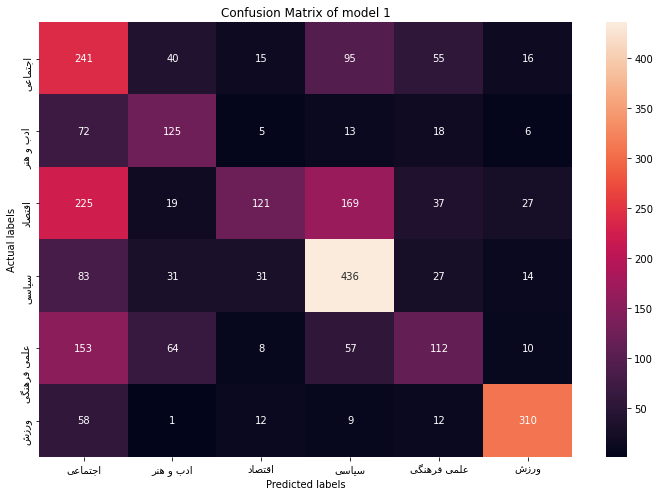

In [29]:
classes = ['اجتماعی', 'ادب و هنر', 'اقتصاد', 'سیاسی', 'علمی فرهنگی', 'ورزش']
confusion_matrix(y_actual_test, y_pred_test)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.29      0.52      0.37       462
           1       0.45      0.52      0.48       239
           2       0.63      0.20      0.31       598
           3       0.56      0.70      0.62       622
           4       0.43      0.28      0.34       404
           5       0.81      0.77      0.79       402

    accuracy                           0.49      2727
   macro avg       0.53      0.50      0.48      2727
weighted avg       0.54      0.49      0.48      2727



### Prepare Dataset for Neural Network

#### Load the custom dataset by defining field objects

torchtext.data has not attribute Field so we should use Field from torchtext.legacy.data and Field doesn't support persian language (tokenizer_language='fa')

In [ ]:
# choose a fixed length to process the string
TEXT = data.Field(tokenize='spacy',
                  pad_first=True,fix_length=20)

Let's define our column name and preprocessing pipline for that column, with tupless in fileds.

In [ ]:
fields = [('preprocessing_text',TEXT),('label', data.Field())]

In [ ]:
train_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/train.csv'
                                , format='csv', fields=fields, skip_header=True)

valid_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv'
                                , format='csv', fields=fields, skip_header=True)

test_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv'
                                , format='csv', fields=fields, skip_header=True)


In [ ]:
type(train_data)

torchtext.legacy.data.dataset.TabularDataset

In [ ]:
len(train_data)

8724

#### Construct Vocabulary

Now, we should construct vocabulary from our text and convert them into integer sequences. The vocabulary contains unique words and assigns an index for each word.

In [ ]:
TEXT.build_vocab(train_data, valid_data,min_freq=3 )

In [ ]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print(" ")
print('-'*200)

#Commonly used words
print(f'10 commonly used words : {TEXT.vocab.freqs.most_common(10)}')  
print(" ")
print('-'*200)

#Word dictionary
print(f'word dictionary : {TEXT.vocab.stoi}') 

Size of TEXT vocabulary: 9802
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
10 commonly used words : [('ایران', 6568), ('کشور', 5182), ('اسلامی', 4086), ('سال', 3229), ('تهران', 3182), ('رئیس', 2631), ('شورا', 2613), ('تیم', 2487), ('جمهوری', 2458), ('گزارش', 2203)]
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
word dictionary : defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f4b1de90410>>, {'<unk>': 0, '<pad>': 1, 'ایران': 2, 'کشور': 3, 'اسلامی': 4, 'سال': 5, 'تهران': 6, 'رئیس': 7, 'شورا': 8, 'تیم': 9, 'جمهوری': 10, 'گزارش': 11, 'سازمان': 12, 'مجلس': 13, 'ملی': 14, 'شرکت': 15, 'شهر': 16, 'سرمایه\u200cگذاری': 17, 'وزیر': 18, 'برگ

#### Function for work with batch

In [ ]:
vocab_size = len(TEXT.vocab)
batch_size = 8
embed_dim = 64
num_class = 6

print(f'vocab size : {vocab_size}')

vocab size : 9802


Using TabularDataset, make our label into a string and put each label into the list. So, when we want to use them, we should convert them back into an integer

In [ ]:
[(elem.label) for elem in train_data][:10]

[['3'], ['3'], ['2'], ['3'], ['4'], ['0'], ['5'], ['0'], ['1'], ['5']]

In [ ]:
preprocessing_text = [elem.preprocessing_text for elem in train_data]

preprocessing_text[1]

['علی',
 'تاجرنیا',
 'نماینده',
 'مشهد',
 'مجلس',
 'انتقاد',
 'محاکمه',
 'سید',
 'مصطفی',
 'تاج',
 'زاده',
 'رئیس',
 'ستاد',
 'انتخابات',
 'کشور',
 'تاج',
 'زاده',
 'جمله',
 'چهره',
 'صداقت',
 'قابلیت',
 'اتفاق',
 'نظر',
 'علی',
 'ظفرزاده',
 'نماینده',
 'مشهد',
 'مجلس',
 'محاکمه',
 'معاون',
 'سیاسی',
 'وزیر',
 'کشور',
 'فشار',
 'گروه',
 'منتقد',
 'دولت',
 'گرفت&گیر']

In [ ]:
TEXT.vocab.stoi[preprocessing_text[1][1]]

4952

In [ ]:
preprocessing_text[1][1]

'تاجرنیا'

Let's define a generare_batch for Dataloader.This function works with batches.

In [ ]:
def generate_batch(batch):
  
  # construct tensor for label
  label = torch.tensor([int(entry.label[0]) for entry in batch])
  
  # construc tensor for preprocessing_text
  # _text consists of integer vectors
  _text = []
  
  for entry in batch:
    # list for indexing words in one text
    _entry = []

    # calculate index of each word in text
    for word in entry.preprocessing_text:
      _entry.append(TEXT.vocab.stoi[word])

    _text.append(torch.tensor(_entry, dtype=torch.long))

  # construct offset list that first element of that is 0 and  other
  # elements are lengths of texts in _text
  offsets = [0] + [len(entry) for entry in _text]  

  # calculate cumulative sum for offsets list except last element 
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  
  # concatenate the given texts (torch.cat can be seen as 
  # an inverse operation for torch.split())
  _text = torch.cat(_text)

  return _text, offsets, label


#### Construct train, valid and test loader

Now, we should define train, valid and test loader.

In [ ]:
# create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, 
                         shuffle=True, collate_fn=generate_batch)

valid_loader = DataLoader(valid_data, batch_size=batch_size, 
                         shuffle=False, collate_fn=generate_batch)

test_loader = DataLoader(test_data, batch_size=batch_size, 
                         shuffle=False, collate_fn=generate_batch)

In [ ]:
print(f'length of train_dataset is : {len(train_data)} and length of train_loader is : {len(train_loader)}')
print(f'length of valid_dataset is : {len(valid_data)} and length of valid_loader is : {len(valid_loader)}')
print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 8724 and length of train_loader is : 1091
length of valid_dataset is : 2181 and length of valid_loader is : 273
length of test_dataset is : 2727 and length of test_loader is : 341


Let's take a look at one batch of train_loader.

In [ ]:
example = iter(train_loader)
text, offset, label = next(example)
print(text, offset, label)
print(f'text shape : {text.shape}, offset shape : {offset.shape}, label shape : {label.shape}')

tensor([ 366,  173, 3878,   32, 4912,   14,  258, 1561,   80, 1673, 2143,  366,
         837,   14,    0,  117, 1327, 7605,   24,   88, 2217, 1046,  458,  299,
         594,   47,  162,    4, 1309, 1095,  366, 6636, 1301,  191, 1547,  174,
        1939,   74, 2976,  134, 4888,   14, 2798, 2772,  366,  330,    0,  366,
         638,  861, 4044,  466,  347,   69,    7,   10,    4,    2,   10, 2016,
         367, 2718,   19,   88, 2418,   69,    7,   10,  466,    2, 1790,  238,
         448,   36,  613,  843,  288,  367,  337,  914,  497, 5912, 4611,    2,
         133, 1040, 5912, 4611,    2,   91,  302,  497, 5912, 4611,   47,  151,
         493,    6,  253,  187, 4383,    6, 2533,  244, 1122,   47,  151,  493,
           2,  387,  107, 6139,   19, 1554,  497, 5912, 4611,  666,  225,  336,
         695, 1230, 1745, 2220, 1123, 1223, 8658,  219, 6396,   23,   15, 1188,
        3532, 5912, 4611, 1040,  210, 1188,   30,  107,  462,    0,  222,  759,
         131,   32, 4309,  850,  236,   

In [ ]:
len(train_loader)

1091

### Building model


In [ ]:
class TextClassificationModel(nn.Module):

  def __init__(self, vocab_size, embed_dim, num_class):
    super(TextClassificationModel, self).__init__()
    self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
    self.fc = nn.Linear(embed_dim, num_class)

    # initialize weights
    self.init_weights()
  
  def init_weights(self):
    initrange = 0.5
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc.weight.data.uniform_(-initrange, initrange)
    self.fc.bias.data.zero_()

  def forward(self, text, offsets):
    embedded = self.embedding(text, offsets)
    return self.fc(embedded)


In [ ]:
model1 = TextClassificationModel(vocab_size, embed_dim, num_class)

In [ ]:
num_epoch = 10
learning_rate= 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.fc.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,1 ,gamma=0.7)


n_total_step = len(train_loader)

In [ ]:
# Define a funciton to calculate accuracy for multi class classification model
def multi_class_acc(y_pred, y_act):

  y_pred_softmax = torch.softmax(y_pred, 1)
  _, y_pred_tag = torch.max(y_pred_softmax,1)

  correct = (y_pred_tag == y_act).float()  # Show which elements are the same with 1
  acc = correct.sum()/len(correct)
  acc = torch.round(acc * 100)

  return acc

### Train and Evaluate model

For monintoring model during the training and evaluating, we can use tensor board.


In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model1_hamshahri_news')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir 'model1_hamshahri_news'

Let's define functions for training and evaluating a model.

In [ ]:
# define a function for training a model
def train(train_loader):
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  
  # train the model
  model1.train()

  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)

  for i , (text, offsets, label) in loop:
    y_pred = model1(text, offsets)
    
    loss_train = criterion(y_pred, label)
    acc_train = multi_class_acc(y_pred, label)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()

    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 

  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)
  

  return train_loss, train_acc


# define a function for evaluating model
def evaluate(valid_loader):

  # validation
  with torch.no_grad():
    model1.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0

    for text_val, offsets_val, label_val in valid_loader:

      y_pred_val = model1(text_val, offsets_val)
      loss_valid = criterion(y_pred_val, label_val)
      acc_valid = multi_class_acc(y_pred_val, label_val) 

      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

  return valid_loss, valid_acc


In [ ]:
from tqdm import tqdm

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epoch):

  train_loss, train_acc = train(train_loader)
  writer.flush() 
  valid_loss, valid_acc = evaluate(valid_loader)  

  scheduler.step()

In [ ]:
torch.save(model1, '/content/drive/MyDrive/AI-Internship/model1_ham') # model1 with 10 epochs

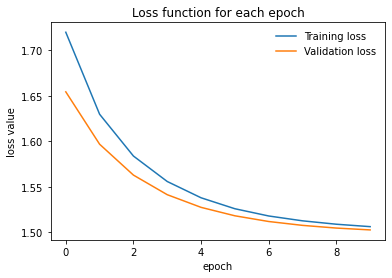

In [ ]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()

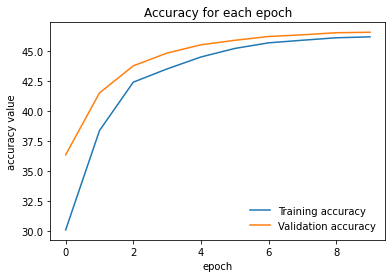

In [ ]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [ ]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [2.8247524899999994e-05],
 '_step_count': 11,
 'base_lrs': [0.001],
 'gamma': 0.7,
 'last_epoch': 10,
 'step_size': 1,
 'verbose': False}

In [ ]:
model1.state_dict

<bound method Module.state_dict of TextClassificationModel(
  (embedding): EmbeddingBag(9802, 64, mode=mean)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)>

In [ ]:
print(f'training loss on last epoch : {train_loss[-1]}')
print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 1.5064260693016018
validation loss on last epoch : 1.5028368684398385
--------------------
training accuracy on last epoch : 46.21173235563703
validation accuracy on last epoch : 46.5970695970696


### Test the model

In [ ]:
classes = ['اجتماعی', 'ادب و هنر', 'اقتصاد', 'سیاسی', 'علمی فرهنگی', 'ورزش']

In [ ]:
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for text, offsets, label in test_loader:

      output = model1(text, offsets)

      _, y_predtest = torch.max(output,1)

      n_true += (y_predtest == label).sum()
      n_total += label.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(label[i])

      for i in range(len(y_predtest)):
        lb = label[i]
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} texts is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test

In [ ]:
y_pred_test, y_actual_test = test(model1, test_loader)

accuracy of network on the 341 texts is : 46.13127899169922
Accuracy of اجتماعی: 8.008658008658008 %
Accuracy of ادب و هنر: 19.246861924686193 %
Accuracy of اقتصاد: 60.03344481605351 %
Accuracy of سیاسی: 79.90353697749197 %
Accuracy of علمی فرهنگی: 20.297029702970296 %
Accuracy of ورزش: 58.95522388059702 %


### Confusion Matrix

Thanks https://medium.com/@amirashabani/pie-chart-and-persian-language-in-python-68dfd03a26fb
about how to print persian words in correct way

In [24]:
# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

def confusion_matrix(y_actual_test, y_pred_test):
  
  plt.figure(figsize = (10,7))
  ax= plt.subplot()
  cnf_matrix = metrics.confusion_matrix(y_actual_test, y_pred_test)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix of model 1'); 
  class_names= classes
  # set persian names in correct way
  class_names = [get_display(reshape(label)) for label in class_names]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()

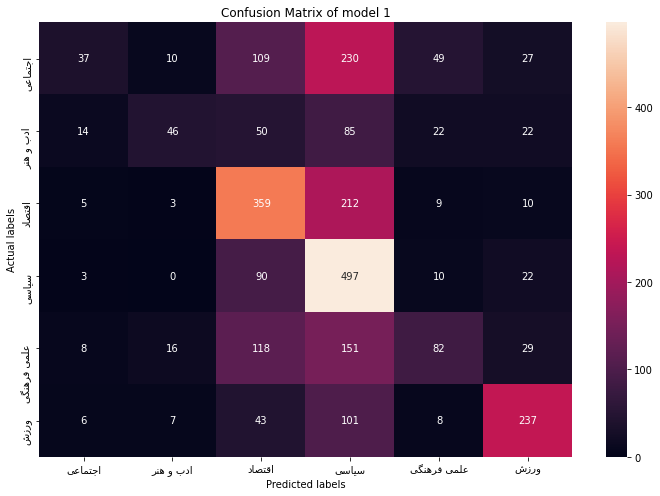

In [ ]:
confusion_matrix(y_actual_test, y_pred_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.51      0.08      0.14       462
           1       0.56      0.19      0.29       239
           2       0.47      0.60      0.53       598
           3       0.39      0.80      0.52       622
           4       0.46      0.20      0.28       404
           5       0.68      0.59      0.63       402

    accuracy                           0.46      2727
   macro avg       0.51      0.41      0.40      2727
weighted avg       0.49      0.46      0.42      2727

